In [1]:
import pandas as pd
import os
import requests
import io
import matplotlib.pyplot as plt
import numpy as np
import nltk
nltk.download('punkt')


import operator

import re
import seaborn as sns

from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
path ='https://raw.githubusercontent.com/tanvi-ap/Covid19StanceDetection/main/Train.csv'
r = requests.get(path)
train_df = pd.read_csv(io.StringIO(r.text),index_col=0)

train_df.sample(5)

,safe_text,label,agreement
tweet_id,,,
4V9ESLN8,State confiscates newborn over vaccinations <u...,0.0,0.666667
CVPWFGZZ,<user> great info today esp reemerging measles...,0.0,0.666667
U9NO969S,<user> <user> <user> my uncle who got a brain ...,0.0,0.666667
V176KJZ3,<user> #GOP STOP blaming #Immigrants first #Eb...,0.0,1.000000
278Q453X,"People who don't vaccinate are idiots, but thi...",1.0,1.000000


In [3]:
train_df['label'].value_counts()

 0.0    4908
 1.0    4054
-1.0    1038
Name: label, dtype: int64

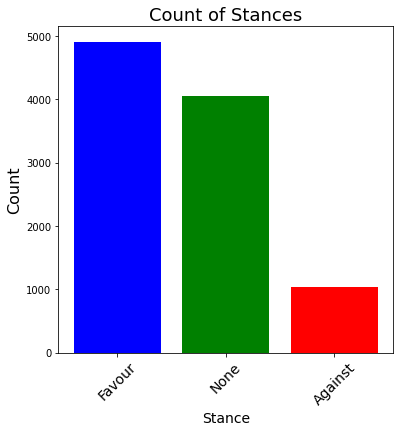

In [5]:
## Plot a distribution of the dataset
plt.figure(figsize=(6,6))
Index = [1,2,3]
Mood_count = train_df['label'].value_counts()

plt.bar(Index, Mood_count, color=['blue','green', 'red'])
plt.xticks(Index,['Favour','None','Against'],rotation=45, fontsize=14)
plt.ylabel('Count', fontsize=16)
plt.xlabel('Stance', fontsize=14)
plt.title('Count of Stances', fontsize=18)
#plt.annotate(text = Mood_count[0], xy = (0.13,22000), size = 18,s=None)

plt.savefig('sentiments_count.png')

count    10001.000000
mean        16.264374
std          5.348448
min          1.000000
25%         13.000000
50%         17.000000
75%         20.000000
max         33.000000
dtype: float64


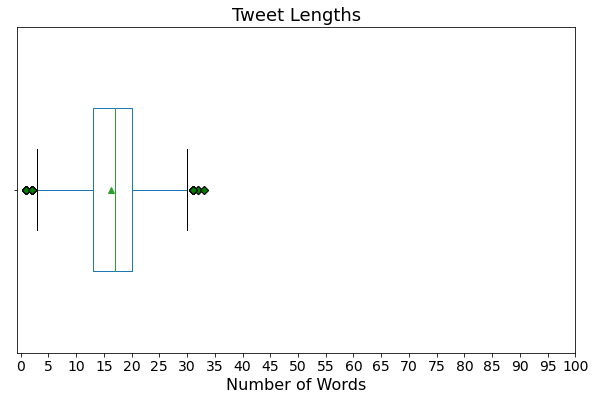

In [8]:
# Calculate tweet lengths
plt.figure(figsize=(10,6))
tweet_len = pd.Series([len(tweet.split()) for tweet in train_df['safe_text']])
print(tweet_len.describe())

# The distribution of tweet text lengths
green_diamond = dict(markerfacecolor='g', marker='D')
tweet_len.plot(kind='box', vert=False, widths=0.5, 
               showmeans=True,
               flierprops=green_diamond)
plt.xlabel('Number of Words', fontsize=16)
plt.xticks(np.arange(0, 101, 5), fontsize=14)
plt.yticks([1], " ")
plt.title("Tweet Lengths", fontsize=18)
plt.show()

In [10]:
df_new = train_df.copy()
df_new['length'] = train_df['safe_text'].str.split().apply(len)
df_new.head()

,safe_text,label,agreement,length
tweet_id,,,,
CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0,15
E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0,25
M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0,7
1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0,28
J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0,20


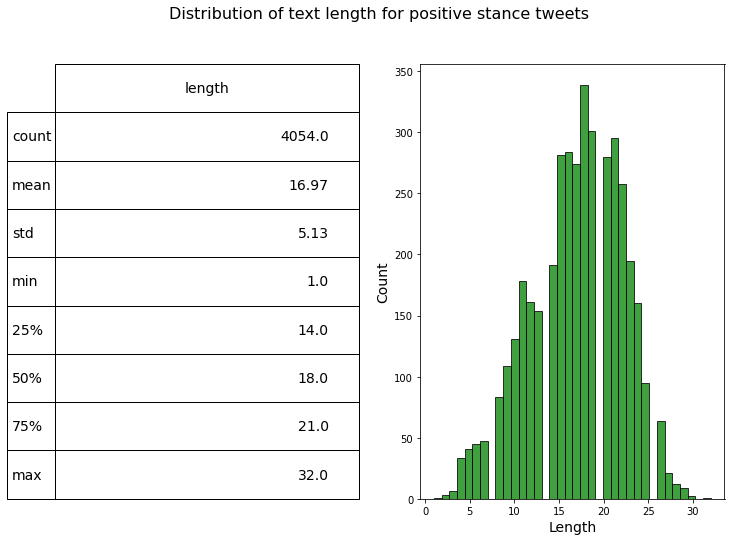

In [12]:
# Plotting the distribution of text length for Favor stance tweets
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(122)
hist = sns.histplot(df_new[df_new['label']==1]['length'], ax=ax1,color='green')
hist.set_xlabel("Length", fontsize = 14)
hist.set_ylabel("Count", fontsize = 14)
describe = df_new.length[df_new['label']==1].describe().to_frame().round(2)
ax1.font_size=14

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive stance tweets', fontsize=16)

plt.show()

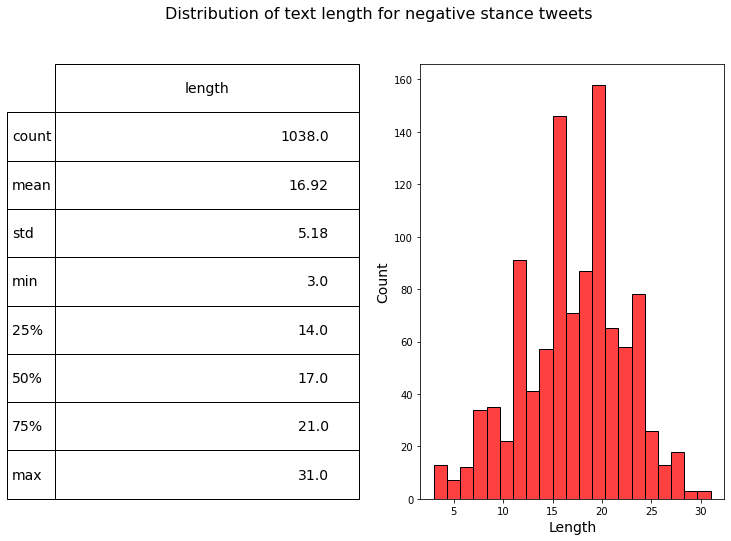

In [14]:
# Plotting the distribution of text length for Against tweets
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(122)
hist = sns.histplot(df_new[df_new['label']==-1]['length'], ax=ax1,color='red')
hist.set_xlabel("Length", fontsize = 14)
hist.set_ylabel("Count", fontsize = 14)
describe = df_new.length[df_new['label']==-1].describe().to_frame().round(2)
ax1.font_size=14

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for negative stance tweets', fontsize=16)

plt.show()

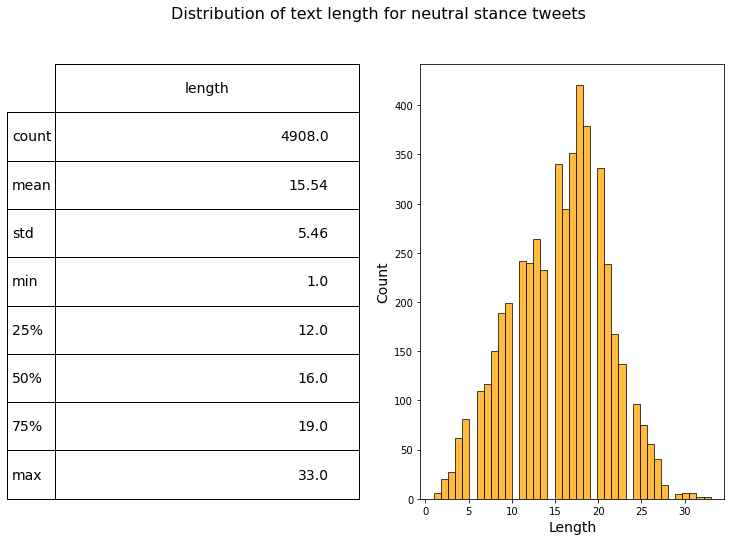

In [15]:
# Plotting the distribution of text length for NONE stance tweets
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(122)
hist = sns.histplot(df_new[df_new['label']==0]['length'], ax=ax1,color='orange')
hist.set_xlabel("Length", fontsize = 14)
hist.set_ylabel("Count", fontsize = 14)
describe = df_new.length[df_new['label']==0].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for neutral stance tweets', fontsize=16)

plt.show()

In [16]:
## Count the frequency of words in a dictionary
def count_frequency(dictionary, words):
    for word in words:
        if word not in dictionary.keys():
            dictionary[word] = 1
        else:
            dictionary[word] += 1
    return dictionary

In [20]:
favour_stance = {}
no_stance = {}
against_stance = {}

for i in range(0,len(train_df)):
    tweet = train_df['safe_text'].iloc[i]
    tweet = tweet.lower()
    new  = re.sub('[^A-Za-z0-9]+', ' ', tweet) ## Need to get rid of special characters next
    tokens = nltk.word_tokenize(new) ## word_tokenize does not remove duplicates
  
    ## Preserve the order because calling set does not preserve the order of the words
    ordered_tokens = set()
    result = []
    for word in tokens:
        if word not in ordered_tokens:
            ordered_tokens.add(word)
            result.append(word)
            
    if (train_df['label'].iloc[i] == 1):
        count_frequency(favour_stance, result) 
    elif (train_df['label'].iloc[i] == -1):
        count_frequency(no_stance, result) 
    else:
        count_frequency(against_stance, result)

In [21]:
pos = sorted(favour_stance.items(),key=operator.itemgetter(1), reverse=True)
neut = sorted(no_stance.items(),key=operator.itemgetter(1), reverse=True)
neg = sorted(against_stance.items(),key=operator.itemgetter(1), reverse=True)

In [22]:
## Create dataframe from a list of tuples
df_pos = pd.DataFrame(pos, columns = ['word', 'frequency']) 
df_neut = pd.DataFrame(neut, columns = ['word', 'frequency'])
df_neg = pd.DataFrame(neg, columns = ['word', 'frequency'])

print("The number of words in tweets with POSITIVE stance is", len(df_pos))
print("The number of words in tweets with NO stance is", len(df_neut))
print("The number of words in tweets with NEGATIVE stance is", len(df_neg))

The number of words in tweets with POSITIVE stance is 7120
The number of words in tweets with NO stance is 3251
The number of words in tweets with NEGATIVE stance is 9455


In [23]:
# A list of dataframes
frame_list = [df_pos, df_neut, df_neg]
inter_all = frame_list[0]
for df in frame_list[1:]:       
    inter_all = pd.merge(inter_all, df, on='word', how='inner')
inter_all = inter_all.rename(columns = {"frequency_x": "positive stance", 
                                        "frequency_y": "neutral stance",
                                       "frequency": "negative stance"})

print("The number of words appearing in tweets with all of positive, neutral, and negative stance is", 
      len(inter_all))
inter_all.head()

The number of words appearing in tweets with all of positive, neutral, and negative stance is 1879


,word,positive stance,neutral stance,negative stance
0,user,1601,564,1873
1,url,1577,411,2383
2,to,1441,291,1300
3,the,1280,362,1564
4,a,940,204,940


In [24]:
inter_pos_neutral = pd.merge(df_pos, df_neut, how = 'inner', on = ['word'])
inter_pos_neutral = inter_pos_neutral.rename(columns = {"frequency_x": "positive stance", "frequency_y": "neutral stance"})
print("The size of the overlap b/w words in POSITIVE and NEUTRAL stance tweets is", len(inter_pos_neutral))
inter_pos_neutral.head(10)

The size of the overlap b/w words in POSITIVE and NEUTRAL stance tweets is 2172


,word,positive stance,neutral stance
0,user,1601,564
1,url,1577,411
2,to,1441,291
3,the,1280,362
4,a,940,204
5,measles,917,105
6,kids,882,111
7,of,873,233
8,vaccinate,770,75
9,and,769,179


In [25]:
inter_pos_neg = pd.merge(df_pos, df_neg, how = 'inner', on = ['word'])
inter_pos_neg = inter_pos_neg.rename(columns={"frequency_x": "positive stance", "frequency_y": "negative stance"})
print("The size of the overlap b/w words in POSITIVE and NEGATIVE stance tweets is", len(inter_pos_neg))
inter_pos_neg.head(10)

The size of the overlap b/w words in POSITIVE and NEGATIVE stance tweets is 3838


,word,positive stance,negative stance
0,user,1601,1873
1,url,1577,2383
2,to,1441,1300
3,the,1280,1564
4,a,940,940
5,measles,917,2289
6,kids,882,211
7,of,873,949
8,vaccinate,770,101
9,and,769,874


In [26]:
inter_neg_neut = pd.merge(df_neg, df_neut, how = 'inner', on = ['word'])
inter_neg_neut = inter_neg_neut.rename(columns={"frequency_x": "negative stance", "frequency_y": "neutral stance"})
print("The size of the overlap b/w words in NEGATIVE and NEUTRAL stance tweets is", len(inter_neg_neut))
inter_neg_neut.head(10)

The size of the overlap b/w words in NEGATIVE and NEUTRAL stance tweets is 2225


,word,negative stance,neutral stance
0,url,2383,411
1,measles,2289,105
2,user,1873,564
3,the,1564,362
4,to,1300,291
5,in,1036,185
6,of,949,233
7,a,940,204
8,and,874,179
9,mmr,813,50


In [27]:
## Remove all words from the positive stance dataframe that overlap with the negative stance dataframe 
## and the neutral stance dataframe

df_pos = df_pos.rename(columns={"frequency": "positive stance"})

## Remove duplicates of words with a negative stance
df_inter = inter_pos_neg[['word', 'positive stance']].copy()
print("The number of words overlapping with positive and negative stance is", len(df_inter))
df1 = pd.concat([df_pos, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df1))

df1 = df1.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df1))
print()

## Remove duplicates of words with a neutral stance
df_inter = inter_pos_neutral[['word', 'positive stance']].copy()
print("The number of words overlapping with positive and neutral stance is", len(df_inter))

df2 = pd.concat([df1, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df2))

df2 = df2.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df2))
print()

print("Subtract off the intersection between all three sets.")
df_inter = inter_all[['word', 'positive stance']].copy()
print("The number of words overlapping with positive, neutral, and negative stance is", len(df_inter))

df3 = pd.concat([df2, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df3))

df3 = df3.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df3))

df_pos_unique = df3.copy()
print("\nThe number of words that correspond only to POSITIVE stance are:", len(df_pos_unique))
print("\n The most common words that correspond only to POSITIVE stance are:")
df_pos_unique.head(20)

The number of words overlapping with positive and negative stance is 3838
The length BEFORE dropping duplicates is 10958
The length AFTER dropping duplicates is 3282

The number of words overlapping with positive and neutral stance is 2172
The length BEFORE dropping duplicates is 5454
The length AFTER dropping duplicates is 4868

Subtract off the intersection between all three sets.
The number of words overlapping with positive, neutral, and negative stance is 1879
The length BEFORE dropping duplicates is 6747
The length AFTER dropping duplicates is 2989

The number of words that correspond only to POSITIVE stance are: 2989

 The most common words that correspond only to POSITIVE stance are:


,word,positive stance
624,psa,12
657,prevented,12
676,uneducated,11
698,irresponsible,11
845,endangering,9
863,charged,8
945,misinformed,7
948,vaxers,7
981,decrease,7
986,blogust,7


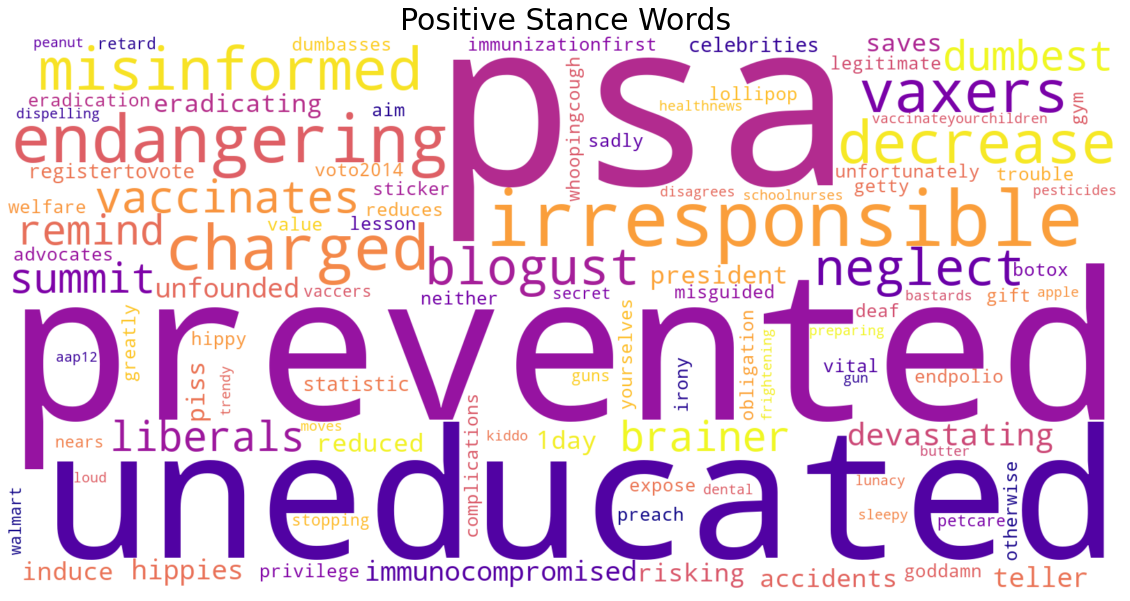

In [28]:
positive_dict = df_pos_unique.set_index('word').T.to_dict('records')

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 100 , width = 1600 , height = 800,
               colormap = "plasma",
               background_color="white").generate_from_frequencies(positive_dict[0])
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title("Positive Stance Words", fontsize =30)
plt.show()

## Save the word cloud to an image
wc.to_file("positive_sent.png")

In [29]:
## Remove all words from the positive stance dataframe that overlap with the negative stance dataframe
## and neutral stance dataframe

df_neg = df_neg.rename(columns={"frequency": "negative stance"})
print("The number of words with NEGATIVE stance", len(df_neg))

## Remove duplicates of words with a positive stance
df_inter = inter_pos_neg[['word', 'negative stance']].copy()
print("The number of words overlapping with positive and negative stance is", len(df_inter))

df1 = pd.concat([df_neg, df_inter], axis=0)
print("The length BEFORE dropping duplicates is", len(df1))
df1 = df1.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df1))
print()

## Remove duplicates of words with a neutral sentiment
df_inter = inter_neg_neut[['word', 'negative stance']].copy()
print("The number of words overlapping with negative and neutral stance is", len(df_inter))

df2 = pd.concat([df1, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df2))
df2 = df2.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df2))
print()

print("Subtract off the intersection between all three sets.")
df_inter = inter_all[['word', 'negative stance']].copy()
print("The number of words overlapping with positive, neutral, and negative stance is", len(df_inter))

df3 = pd.concat([df2, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df3))

df3 = df3.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df3))

df_neg_unique = df3.copy()
print("\nThe number of words that correspond only to NEGATIVE stance are:", len(df_neg_unique))
print("\nThe most common words that correspond only to NEGATIVE stance are:")
df_neg_unique.head(20)

The number of words with NEGATIVE stance 9455
The number of words overlapping with positive and negative stance is 3838
The length BEFORE dropping duplicates is 13293
The length AFTER dropping duplicates is 5617

The number of words overlapping with negative and neutral stance is 2225
The length BEFORE dropping duplicates is 7842
The length AFTER dropping duplicates is 7150

Subtract off the intersection between all three sets.
The number of words overlapping with positive, neutral, and negative stance is 1879
The length BEFORE dropping duplicates is 9029
The length AFTER dropping duplicates is 5271

The number of words that correspond only to NEGATIVE stance are: 5271

The most common words that correspond only to NEGATIVE stance are:


,word,negative stance
63,tension,172
65,releasing,170
188,dj,49
242,mixmasterrod,37
249,madhatterdc,36
287,jennifair,31
332,improves,26
369,dupontcircle,24
452,lounge,19
485,photoshop,18


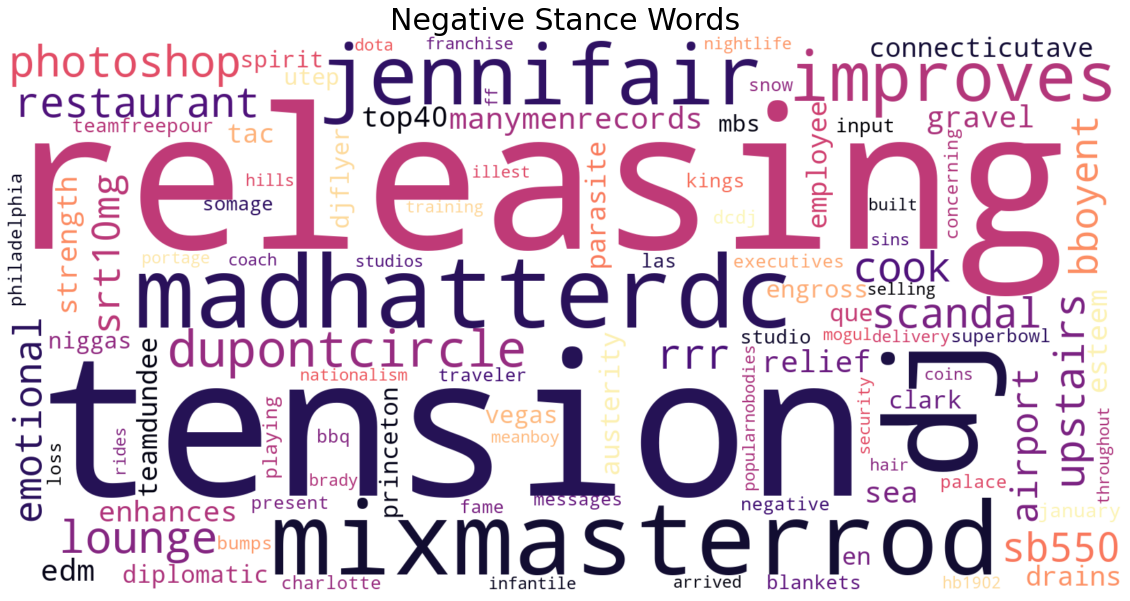

In [30]:
negative_dict = df_neg_unique.set_index('word').T.to_dict('records')

## Make a word cloud of words the correspond to negative stance only
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 100 , width = 1600 , height = 800, 
               background_color="white",
               colormap = "magma").generate_from_frequencies(negative_dict[0])
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title("Negative Stance Words", fontsize =30)
plt.show()

## Save the word cloud to an image
wc.to_file("negative_sent.png")

In [31]:
# Remove all words from the neutral stance dataframe that overlap with the negative stance dataframe 
# nd positive stance dataframe

df_neut = df_neut.rename(columns={"frequency": "neutral stance"})
print("The number of words with NEUTRAL stance", len(df_neut))

## Remove duplicates of words with a positive stance
df_inter = inter_pos_neutral[['word', 'neutral stance']].copy()
print("The number of words overlapping with positive and neutral stance is", len(df_inter))

df1 = pd.concat([df_neut, df_inter], axis=0)

print("The length BEFORE dropping duplicates is", len(df1))
df1 = df1.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df1))
print()

## Remove duplicates of words with a negative stance
df_inter = inter_neg_neut[['word', 'neutral stance']].copy()
print("The number of words overlapping with negative and neutral stance is", len(df_inter))

df2 = pd.concat([df1, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df2))
df2 = df2.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df2))
print()

print("Subtract off the intersection between all three sets.")
df_inter = inter_all[['word', 'neutral stance']].copy()
print("The number of words overlapping with positive, neutral, and negative stance is", len(df_inter))

df3 = pd.concat([df2, df_inter], axis = 0)
print("The length BEFORE dropping duplicates is", len(df3))

df3 = df3.drop_duplicates(keep=False)
print("The length AFTER dropping duplicates is", len(df3))

df_neutral_unique = df3.copy()
print("\nThe number of words that correspond only to NEUTRAL stance are:", len(df_neutral_unique))
print("\nThe most common words that correspond only to NEUTRAL stance are:")
df_neutral_unique.head(20)

The number of words with NEUTRAL stance 3251
The number of words overlapping with positive and neutral stance is 2172
The length BEFORE dropping duplicates is 5423
The length AFTER dropping duplicates is 1079

The number of words overlapping with negative and neutral stance is 2225
The length BEFORE dropping duplicates is 3304
The length AFTER dropping duplicates is 2612

Subtract off the intersection between all three sets.
The number of words overlapping with positive, neutral, and negative stance is 1879
The length BEFORE dropping duplicates is 4491
The length AFTER dropping duplicates is 733

The number of words that correspond only to NEUTRAL stance are: 733

The most common words that correspond only to NEUTRAL stance are:


,word,neutral stance
312,hearthiswell,8
357,courts,7
454,dpt,5
492,italian,5
494,cdcwhisleblower,5
510,bigpharma,5
517,injure,4
524,epa,4
526,4ppm,4
549,vaccineinjured,4


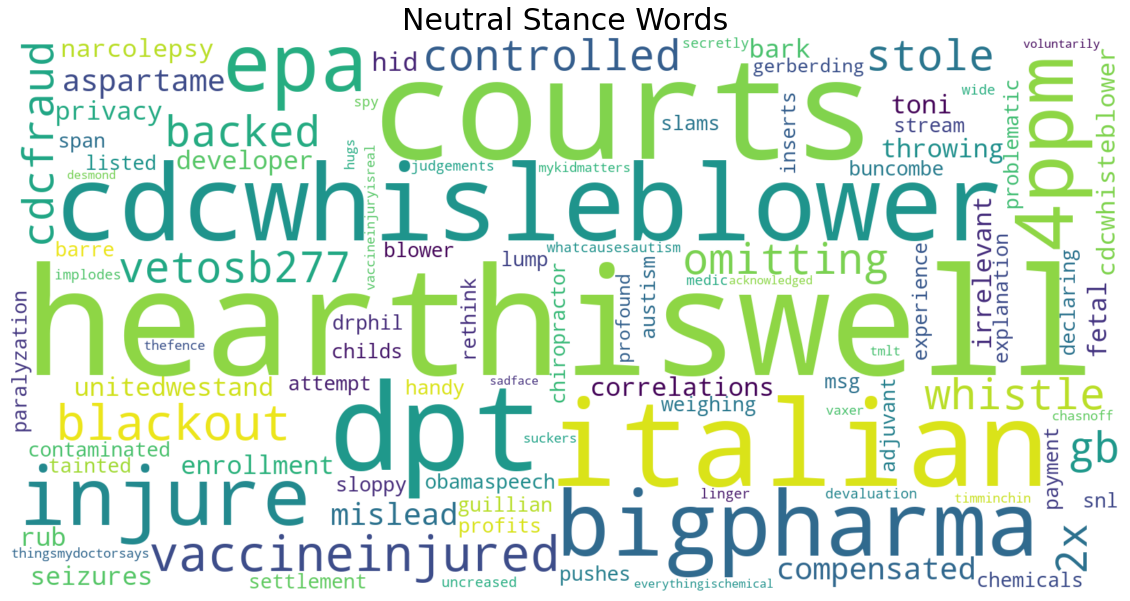

In [32]:
neutral_dict = df_neutral_unique.set_index('word').T.to_dict('records')

## Make a word cloud of words the correspond to neutral stance only
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 100 , width = 1600 , height = 800,
               background_color="white").generate_from_frequencies(neutral_dict[0])
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title("Neutral Stance Words", fontsize =30)
plt.show()

## Save the word cloud to an image
wc.to_file("neutral_sent.png")